# Intrabeam scattering

This notebook introduces the ``Intrabeam scattering`` class for **mbtrack2**:

The ``Intrabeam scattering`` is a class computes the IBS growth rate analytically each turn and apply corresponding kicks to each particle.


# Tracking set-up

We begin by importing relevant libraries

In [76]:
import numpy as np
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.impedance.wakefield import WakeField
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import IntrabeamScattering
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
import at
import matplotlib.pyplot as plt

We define our lattice:
*   for this notebook we will use a ring with a lattice file to be able to illustrate the beta function and the scattering computations, however the code can still compute with average optic values if no lattice is loaded. For that we need to introduce a small dispersion at the order of $10^{-3}$

In [77]:
def soleil(mode = 'Uniform', load_lattice = True, IDs = "close"):
    """
    
    """

    h = 416
    particle = Electron()
    tau = np.array([6.56e-3, 6.56e-3, 3.27e-3])
    emit = np.array([3.9e-9, 3.9e-9*0.01])
    sigma_0 = 15e-12
    sigma_delta = 1.025e-3
    if load_lattice:  
        lattice_file = "SOLEIL_OLD.mat" 
        alpha = np.array([0, 0])

        optics = Optics(lattice_file=lattice_file, local_alpha=alpha, n_points=1e4)
        
        ring = Synchrotron(h, optics, particle, tau=tau, emit=emit, 
                           sigma_0=sigma_0, sigma_delta=sigma_delta)
    
    else:    
        L = 3.540969742590899e+02
        E0 = 2.75e9
    
        ac = 4.16e-4
        U0 = 1.171e6
    
        tune = np.array([18.15687, 10.22824, 0.00502])
    
        chro = [1.4,2.3]
    
        # mean values
        beta = np.array([3, 1.3])
        alpha = np.array([0, 0])
        dispersion = np.array([1e-3, 1e-3, 1e-3, 1e-3])
        optics = Optics(local_beta=beta, local_alpha=alpha, 
        local_dispersion=dispersion)
        
        ring = Synchrotron(h, optics, particle, L=L, E0=E0, ac=ac, U0=U0, tau=tau,
        emit=emit, tune=tune, sigma_delta=sigma_delta, 
        sigma_0=sigma_0, chro=chro)

    return ring

In [78]:
ring = soleil()

This is not necessary but we can introduce a small 30% white noise coupling that we can turn on and off to be able to see the difference in the Intrabeam scattering (``IBS``) effect.

In [79]:
coupling = 30
ring.emit[1] = (coupling/100)*ring.emit[0]

We define and intialize the bunch.

In [80]:
n_macroparticles = 10000
bunch_current = 1.2e-3

mybunch = Bunch(ring, mp_number=n_macroparticles, current=bunch_current, track_alive=True)
np.random.seed(42)
mybunch.init_gaussian()

We define and initialize the RF Cavity.

In [81]:
V_rf  = 1.8e6 #1.8e6
rf_single = RFCavity(ring, m=1, Vc=V_rf, theta=np.arccos(ring.U0 / V_rf))

We define the tracking elements that we are going to use.

In [82]:
n_bin = 100
modelname = "PS"
long_map = LongitudinalMap(ring)
trans_map = TransverseMap(ring)
sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
ibs = IntrabeamScattering(ring, mybunch, model=modelname, n_points=1000 ,n_bin=n_bin)    #Intrabeam scattering

# Tracking

First we make a pass with Longitudinal an transverse map, as well as Synchrotron radiation and RF Cavity

In [83]:
long_map.track(mybunch)
trans_map.track(mybunch)
rf_single.track(mybunch)
sr.track(mybunch)

The IBS tracking method will call 4 class methods:
*    Initialize the bunch
*    Compute the scattering integrals
*    computes the growth rate
*    apply the kick to the bunch by adding momentum to xp, yp, delta hence causing the emittance to grow

initialize will compute the parameters that need to be updated each turn this method will be called each turn, contrary to ``__init__`` that will initialize only the static parameters which are the lattice optical functions.

In [84]:
ibs.initialize(mybunch)

We begin by using the Piwinsky standard to compute scattering, it is important to note that for each model, scatter() function will return different sets of arrays:
*   For Piwniski Standard and modified ``PS`` and ``PM`` it returns 3 arrays: ``vabq`` and ``v1aq`` and ``v1bq`` which are the computed values of the functions $f(a,b,q)$ and $f(\frac{1}{b},\frac{a}{b},\frac{q}{b})$ and $f(\frac{1}{a},\frac{b}{a},\frac{q}{a})$.
*   For ``Bane`` model, the function will return ``gval``, which is the computed values of the function $g_{Bane}(\alpha)$
*   For Completely integrated modified Piwinski ``CIMP`` the function returns ``g_ab``, and ``g_ba`` which are the values of $g(\frac{a}{b})$ and $g(\frac{b}{a})$ of the function $g(\omega)$.

All the formulas are summarized nicely in this paper[1]:

[1]K. Kubo, S. K. Mtingwa, and A. Wolski, Intrabeam Scattering Formulas for High Energy Beams, Phys. Rev. ST Accel. Beams 8, 081001 (2005).
https://doi.org/10.1103/PhysRevSTAB.8.081001

In [85]:
vabq, v1aq, v1bq = ibs.scatter()

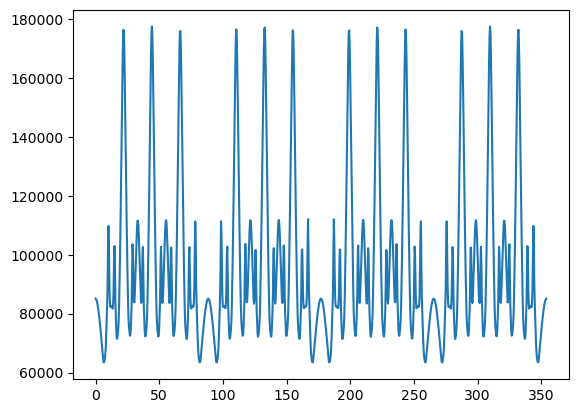

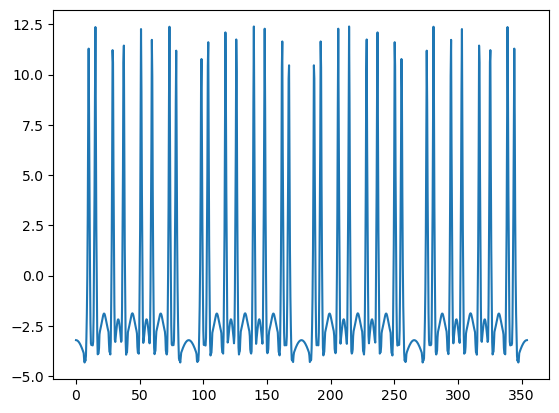

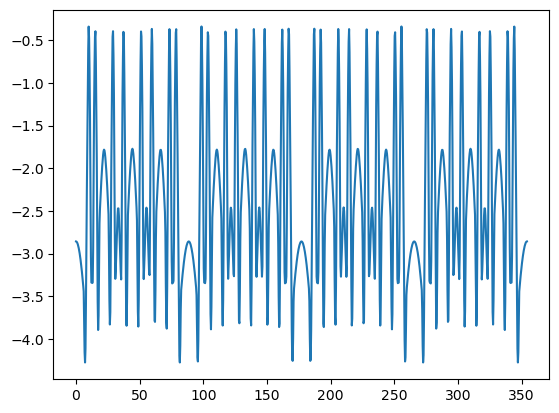

In [86]:
s = np.linspace(0, ring.L, 1000) # longitudinal axis along the ring in [m]
for el in [vabq, v1aq, v1bq]:
    plt.plot(s, el)
    plt.show()

After computing the scattering values the code will plug the numbers in the next method to compute the growth rate ``T_x`` and ``T_y`` and ``T_p``

In [87]:
T_x, T_y, T_p = ibs.get_scatter_T(vabq=vabq, v1aq=v1aq, v1bq=v1bq)
print(T_x, T_y, T_p)

0.0816199387078466 0 0.09696889719383568


We can see that the vertical growth rate is zero, this is normal since the code will set the value to zero if the result is negative, since the growth time is strictly positive and the IBS class only computes the growth, the damping is done by Synchrotron radiation class

Although gorwth rate is called T_ibs, to get the time we need to take the inverse, the time in 4th generation lattices for example is in the order of miliseconds.

In [88]:
print(1/T_x, 1/T_p)

12.251908244864488 10.31258505498988


The tracking method will plug the growth rate number into the kick method which increased the bunch emittance

In [89]:
ibs.kick(mybunch, T_x, T_y, T_p)

We can run few kicks to check our emittance

In [90]:
print(mybunch.emit)

[3.88496350e-09 1.17889055e-09 1.54785101e-14]


In [91]:
for i in range(100):
    ibs.kick(mybunch, T_x, T_y, T_p)

In [92]:
print(mybunch.emit)

[3.88506463e-09 1.17889055e-09 1.54780434e-14]


Since the beam is relatively large for IBS to be effective in ``SOLEIL`` lattice parameters, IBS effect is weak. So, for the sake of the example we can test with stronger IBS by plugging growth rate at the order of 1 miliseconds, after 10 thousand turns we can clearly see the emittance growth. This growth usually comes to an equilibrium when we include Synchrotron radiation.

In [93]:
T_x = 1/5e-4
T_y = 1/15e-4
T_p = 1/10e-4 
emit = []
for i in range(10000):
    ibs.kick(mybunch, T_x, T_y, T_p)
    emit.append(mybunch.emit)

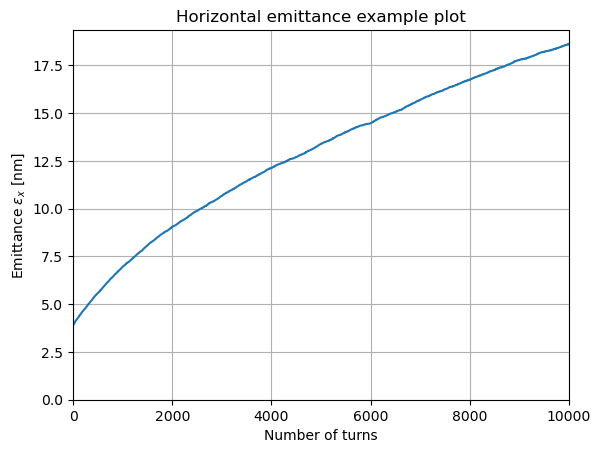

In [94]:
emit = np.array(emit)
plt.plot(emit[:,0]*1e9)
plt.title("Horizontal emittance example plot")
plt.xlabel("Number of turns")
plt.ylabel("Emittance $\epsilon_x$ [nm]")
plt.xlim(0,10000)
plt.ylim(0,)
plt.grid()
plt.show()

# Using Piwinski modified

Same procedure as before using Piwinski modified

In [95]:
ring = soleil()
coupling = 30
ring.emit[1] = (coupling/100)*ring.emit[0]
n_macroparticles = 10000
bunch_current = 1.2e-3
mybunch = Bunch(ring, mp_number=n_macroparticles, current=bunch_current, track_alive=True)
np.random.seed(42)
mybunch.init_gaussian()
n_bin = 100
modelname = "PM"
long_map = LongitudinalMap(ring)
trans_map = TransverseMap(ring)
sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
ibs = IntrabeamScattering(ring, mybunch, model=modelname, n_points=1000 ,n_bin=n_bin)    #Intrabeam scattering
long_map.track(mybunch)
trans_map.track(mybunch)
rf_single.track(mybunch)
sr.track(mybunch)

In [96]:
ibs.initialize(mybunch)

In [97]:
vabq, v1aq, v1bq = ibs.scatter()

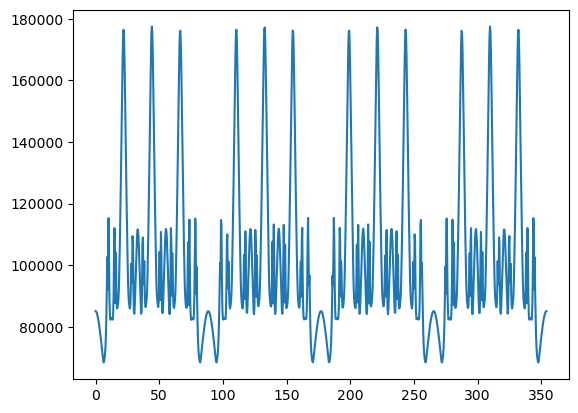

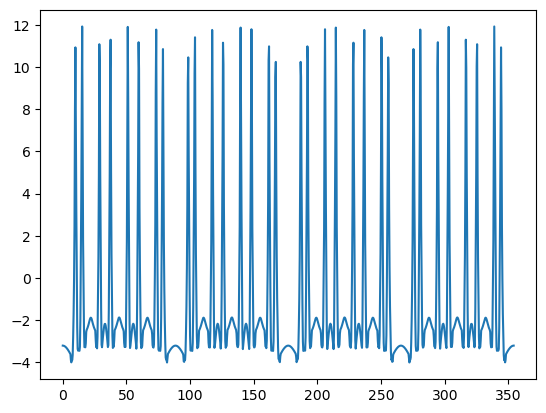

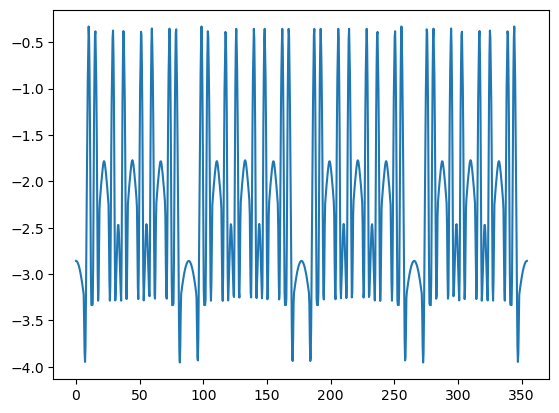

In [98]:
for el in [vabq, v1aq, v1bq]:
    plt.plot(s, el)
    plt.show()

In [99]:
T_x, T_y, T_p = ibs.get_scatter_T(vabq=vabq, v1aq=v1aq, v1bq=v1bq)
print(T_x, T_y, T_p)

0.07804402354466485 0 0.0912842121615706


In [100]:
print(mybunch.emit)

[3.88494969e-09 1.17889055e-09 1.54784419e-14]


In [101]:
for i in range(100):
    ibs.kick(mybunch, T_x, T_y, T_p)

In [102]:
print(mybunch.emit)

[3.88506230e-09 1.17889055e-09 1.54781131e-14]


In [103]:
T_x = 1/5e-4
T_y = 1/15e-4
T_p = 1/10e-4
emit = []
for i in range(10000):
    ibs.kick(mybunch, T_x, T_y, T_p)
    emit.append(mybunch.emit)

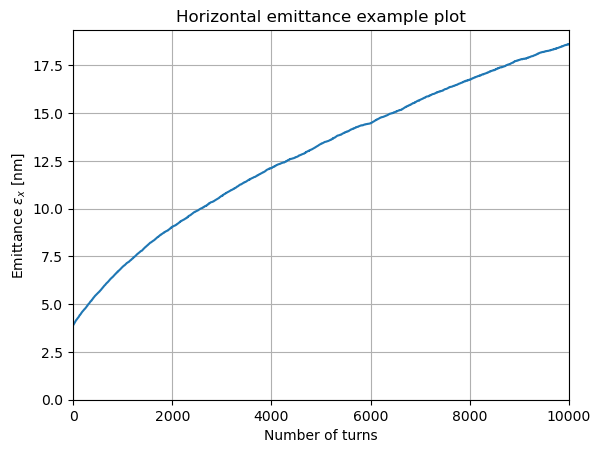

In [104]:
emit = np.array(emit)
plt.plot(emit[:,0]*1e9)
plt.title("Horizontal emittance example plot")
plt.xlabel("Number of turns")
plt.ylabel("Emittance $\epsilon_x$ [nm]")
plt.xlim(0,10000)
plt.ylim(0,)
plt.grid()
plt.show()

# Using Bane model

Same procedure as before using Bane

In [105]:
ring = soleil()
coupling = 30
ring.emit[1] = (coupling/100)*ring.emit[0]
n_macroparticles = 10000
bunch_current = 1.2e-3
mybunch = Bunch(ring, mp_number=n_macroparticles, current=bunch_current, track_alive=True)
np.random.seed(42)
mybunch.init_gaussian()
n_bin = 100
modelname = "Bane"
long_map = LongitudinalMap(ring)
trans_map = TransverseMap(ring)
sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
ibs = IntrabeamScattering(ring, mybunch, model=modelname, n_points=1000 ,n_bin=n_bin)    #Intrabeam scattering
long_map.track(mybunch)
trans_map.track(mybunch)
rf_single.track(mybunch)
sr.track(mybunch)

In [106]:
ibs.initialize(mybunch)

In [107]:
gval = ibs.scatter()

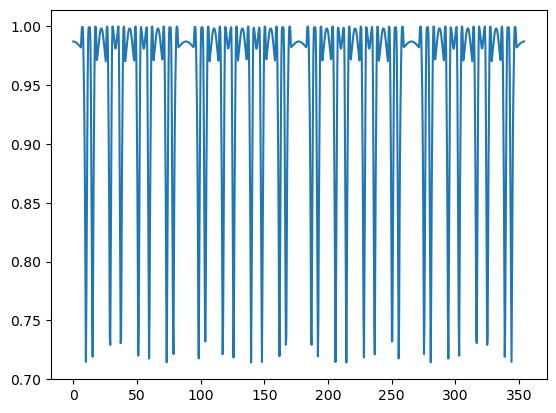

In [108]:
plt.plot(s, gval)
plt.show()

In [109]:
T_x, T_y, T_p = ibs.get_scatter_T(gval=gval)
print(T_x, T_y, T_p)

0.1121185311396047 0 0.10480688148513802


In [110]:
print(mybunch.emit)

[3.88494969e-09 1.17889055e-09 1.54784419e-14]


In [111]:
for i in range(100):
    ibs.kick(mybunch, T_x, T_y, T_p)

In [112]:
print(mybunch.emit)

[3.88508878e-09 1.17889055e-09 1.54780956e-14]


In [113]:
T_x = 1/5e-4
T_y = 1/15e-4
T_p = 1/10e-4
emit = []
for i in range(10000):
    ibs.kick(mybunch, T_x, T_y, T_p)
    emit.append(mybunch.emit)

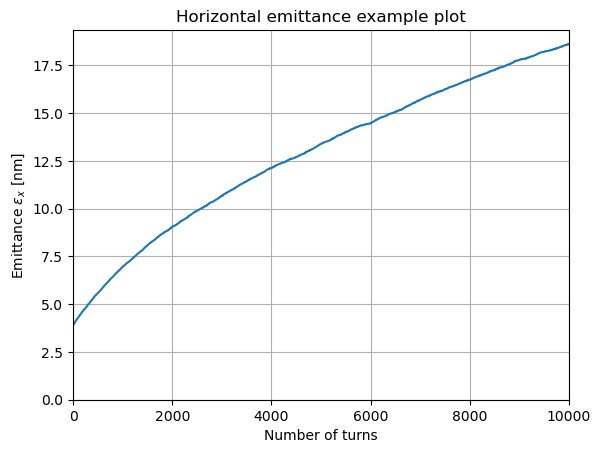

In [114]:
emit = np.array(emit)
plt.plot(emit[:,0]*1e9)
plt.title("Horizontal emittance example plot")
plt.xlabel("Number of turns")
plt.ylabel("Emittance $\epsilon_x$ [nm]")
plt.xlim(0,10000)
plt.ylim(0,)
plt.grid()
plt.show()

# Using Completely Integrated Modified Piwinski

Same procedure as before using CIMP

In [115]:
ring = soleil()
coupling = 30
ring.emit[1] = (coupling/100)*ring.emit[0]
n_macroparticles = 10000
bunch_current = 1.2e-3
mybunch = Bunch(ring, mp_number=n_macroparticles, current=bunch_current, track_alive=True)
np.random.seed(42)
mybunch.init_gaussian()
n_bin = 100
modelname = "CIMP"
long_map = LongitudinalMap(ring)
trans_map = TransverseMap(ring)
sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
ibs = IntrabeamScattering(ring, mybunch, model=modelname, n_points=1000 ,n_bin=n_bin)    #Intrabeam scattering
long_map.track(mybunch)
trans_map.track(mybunch)
rf_single.track(mybunch)
sr.track(mybunch)

In [116]:
ibs.initialize(mybunch)

In [117]:
g_ab, g_ba = ibs.scatter()

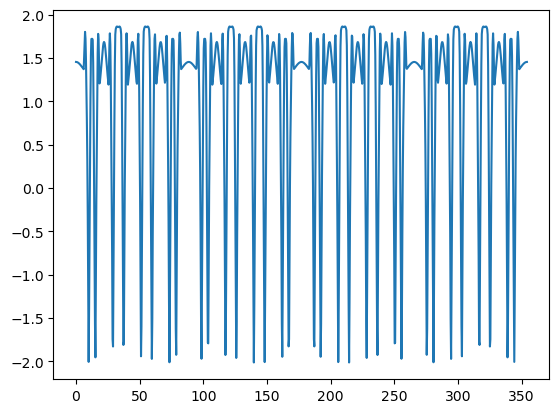

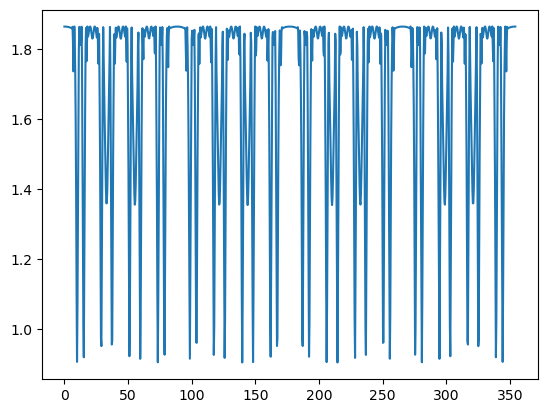

In [118]:
for i in [g_ab, g_ba]:
    plt.plot(s, i)
    plt.show()

In [119]:
T_x, T_y, T_p = ibs.get_scatter_T(g_ab=g_ab, g_ba=g_ba)
print(T_x, T_y, T_p)

0.11176798297598188 0 0.10484779974039443


In [120]:
print(mybunch.emit)

[3.88494969e-09 1.17889055e-09 1.54784419e-14]


In [121]:
for i in range(100):
    ibs.kick(mybunch, T_x, T_y, T_p)

In [122]:
print(mybunch.emit)

[3.88508852e-09 1.17889055e-09 1.54780956e-14]


In [123]:
T_x = 1/5e-4
T_y = 1/15e-4
T_p = 1/10e-4
emit = []
for i in range(10000):
    ibs.kick(mybunch, T_x, T_y, T_p)
    emit.append(mybunch.emit)

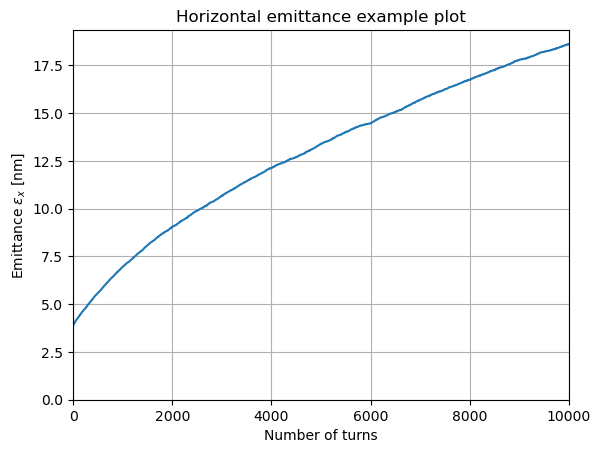

In [124]:
emit = np.array(emit)
plt.plot(emit[:,0]*1e9)
plt.title("Horizontal emittance example plot")
plt.xlabel("Number of turns")
plt.ylabel("Emittance $\epsilon_x$ [nm]")
plt.xlim(0,10000)
plt.ylim(0,)
plt.grid()
plt.show()